In [ ]:
#import data #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf #this is for fatching our data
import time
from scipy import stats
from pandas_datareader import data as pdr
import datetime as dt
%matplotlib inline

In [ ]:
!pip install --quiet yfinance

In [ ]:
ticker = ['AAPL','MSFT','GOOGL','AMZN']
weights = np.array([0.25,0.25,0.25,0.25])

start = dt.datetime(2020,1,1)
end = dt.datetime.today()

price = pd.DataFrame(index=pd.date_range(start,end))

# print(price)

for t in ticker:
  print(f"fetching{ticker}",end = "")
  try:
    ## featching the data
    df = yf.Ticker(ticker).history(start=start.strftime("%Y-%m-%d"),end = end.strftime("%Y-%m-%d"),auto_adjust=True,)
    series = df['Close']
    print("Y finance ",end="")
  except Exception as e:
    print(f"X yfinance ({e}); falling back to Stooq")
    df2 = pdr.DataReader(ticker,'stooq',start,end)
    df2 = df2.sort_index()
    series= df2['Close']

  price[ticker] = series
  time.sleep(1)

price = price.dropna(how='all').ffill().bfill()
print(price.tail())

fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
              AAPL    MSFT   GOOGL    AMZN
2025-05-14  212.33  452.94  165.37  210.25
2025-05-15  211.45  453.13  163.96  205.17
2025-05-16  211.26  454.27  166.19  205.59
2025-05-19  208.78  458.87  166.54  206.16
2025-05-20  206.86  458.17  163.98  204.07


In [ ]:
## Compute Daily Log-Return
## log-return = ln(P_t / P_{t-1})

In [ ]:
logR = np.log(price/price.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
2020-01-03,-0.009737,-0.012360,-0.005243,-0.012213
2020-01-06,0.007879,0.002580,0.026304,0.014776
2020-01-07,-0.004666,-0.009299,-0.001935,0.002089
2020-01-08,0.015943,0.016008,0.007094,-0.007839
2020-01-09,0.021054,0.012240,0.010441,0.004788


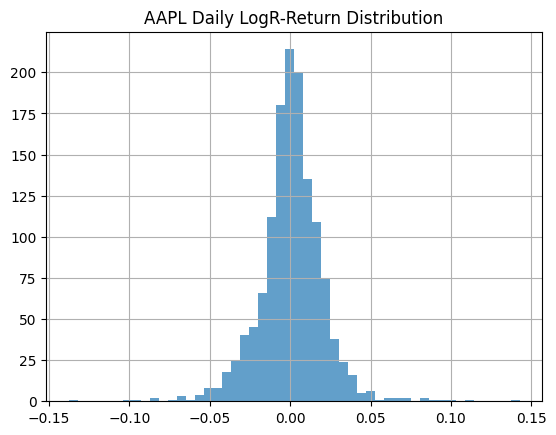

In [ ]:
logR['AAPL'].hist(bins=50,alpha=0.7)
plt.title('AAPL Daily LogR-Return Distribution')
plt.show()

In [ ]:
## Mean(avg daily return) , Variance(how much return vary) , Skewness(asymmetry) , Kurtosis(tail-heaviness)

In [ ]:
summary = pd.DataFrame(index=logR.columns)
summary['Mean'] = logR.mean()
summary['Variance'] = logR.var()
summary['Skewness'] = logR.skew()
summary['Kurtosis'] = logR.kurtosis()
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000773,0.000425,0.018529,6.231009
MSFT,0.000808,0.000373,-0.165383,7.423263
GOOGL,0.000649,0.000431,-0.225541,3.643160
AMZN,0.000566,0.000524,-0.069903,4.156126


In [ ]:
### fit parametric distribution & 95% cls

In [ ]:
## calculate mean and std deviation

In [ ]:
from scipy import stats
mu_norm , sigma_norm = logR.stack().mean(),logR.stack().std(ddof = 1)
# 95% CI for mean under Normal: mu +- z*.sigma/sqrt(N)
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95*sigma_norm/np.sqrt(N),mu_norm + z95*sigma_norm/np.sqrt(N))

#
df = N-1
chi2_low,chi2_high = stats.chi2.ppf(0.025,df),stats.chi2.ppf(0.975,df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),sigma_norm*np.sqrt(df/chi2_low))

print("Normal fit:")
print(f"mu = {mu_norm},95% CI = {ci_mu_norm}")
print(f"sigma = {sigma_norm},95% CI = {ci_sigma_norm}")

Normal fit:
mu = 0.0006992253751830742,95% CI = (np.float64(0.00014139280198295504), np.float64(0.0012570579483831934))
sigma = 0.02093023577593315,95% CI = (np.float64(0.020543110169780183), np.float64(0.021332338016669325))


In [ ]:
returns_flat = logR.stack().dropna().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

In [ ]:
## Bootstraping Setup

In [ ]:
## 95% CI for mu and sigma of a t-fit is more complex
B= 1000
## resample & fit
estimates = np.array([stats.t.fit(np.random.choice(returns_flat,size = N,replace = True))for _ in range(B)])
## Calculate Cofidence interval
ci_mu_t = np.percentile(estimates[:,1],[2.5,97.5])
ci_sigma_t = np.percentile(estimates[:,2],[2.5,97.5])

print("t-distribution fit:")
print(f"df = {df_t:.1f}")
print(f"mu = {mu_t:.5f}, 95% CI = ({ci_mu_t[0]:.5f}, {ci_mu_t[1]:.5f})")
print(f"sigma = {sigma_t:.5f}, 95% CI = ({ci_sigma_t[0]:.5f}, {ci_sigma_t[1]:.5f})")

t-distribution fit:
df = 3.6
mu = 0.00105, 95% CI = (0.00058, 0.00151)
sigma = 0.01446, 95% CI = (0.01397, 0.01497)


In [ ]:
# Historical VaR (Value at Risk)
# Compute portfolio log returns first
portR = logR.dot(weights)

# Calculate 5% Value at Risk (VaR)
hist_var = -np.percentile(portR, 5)
print(f"Historical VaR at 5% level: {hist_var:.5f}")


Historical VaR at 5% level: 0.02893


In [ ]:
# 1. Normal Distribution VaR at 5%
z_5 = stats.norm.ppf(0.05)  # 5th percentile (left tail)
var_norm = -(mu_norm + z_5 * sigma_norm)
print(f"Normal Distribution VaR at 5% level: {var_norm:.5f}")


Normal Distribution VaR at 5% level: 0.03373


In [ ]:
# 2. Student's t-distribution VaR at 5%
t_5 = stats.t.ppf(0.05, df_t)  # 5th percentile for t-distribution
var_t = -(mu_t + t_5 * sigma_t * np.sqrt((df_t - 2) / df_t))  # scale t std deviation
print(f"Student's t-Distribution VaR at 5% level: {var_t:.5f}")


Student's t-Distribution VaR at 5% level: 0.02026


In [ ]:
portR_clean = portR.dropna()
t_stat, p_value = stats.ttest_1samp(portR_clean, 0)


In [ ]:
print(f"T-statistic: {t_stat:.5f}")
print(f"P-value: {p_value:.5f}")

alpha = 0.05
if p_value < alpha:
    print("Reject H₀: Mean return is significantly different from 0.")
else:
    print("Fail to reject H₀: No evidence mean return is different from 0.")

T-statistic: 1.41459
P-value: 0.15742
Fail to reject H₀: No evidence mean return is different from 0.


In [ ]:
#Corelation matrix

correlation_matrix = logR.corr()
print(correlation_matrix)


           AAPL      MSFT     GOOGL      AMZN
AAPL   1.000000  0.734379  0.646412  0.607076
MSFT   0.734379  1.000000  0.736936  0.685791
GOOGL  0.646412  0.736936  1.000000  0.655926
AMZN   0.607076  0.685791  0.655926  1.000000


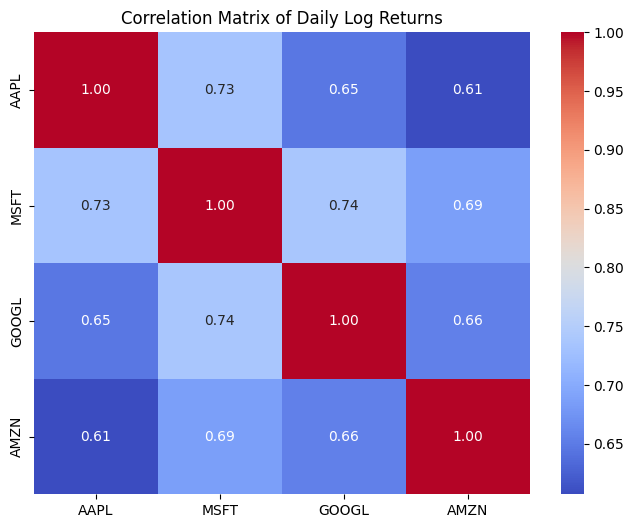

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Daily Log Returns")
plt.show()


In [ ]:
# Step 1: Compute cumulative portfolio returns
cum_port = (1 + portR).cumprod()

# Step 2: Track the rolling max (highest value reached so far)
rolling_max = cum_port.cummax()

# Step 3: Compute drawdown
drawdown = (cum_port - rolling_max) / rolling_max

# Step 4: Find max drawdown
max_dd = drawdown.min()

# Step 5: Find end date (when max drawdown occurred)
end_date = drawdown.idxmin()

# Step 6: Find start date (last time portfolio was at a peak before the drawdown)
start_date = cum_port.loc[:end_date].idxmax()

print(f"📉 Maximum Drawdown (MDD): {max_dd:.2%}")
print(f"🔼 Start of Drawdown: {start_date.date()}")
print(f"🔽 End of Drawdown (trough): {end_date.date()}")


📉 Maximum Drawdown (MDD): -43.98%
🔼 Start of Drawdown: 2021-12-10
🔽 End of Drawdown (trough): 2023-01-05


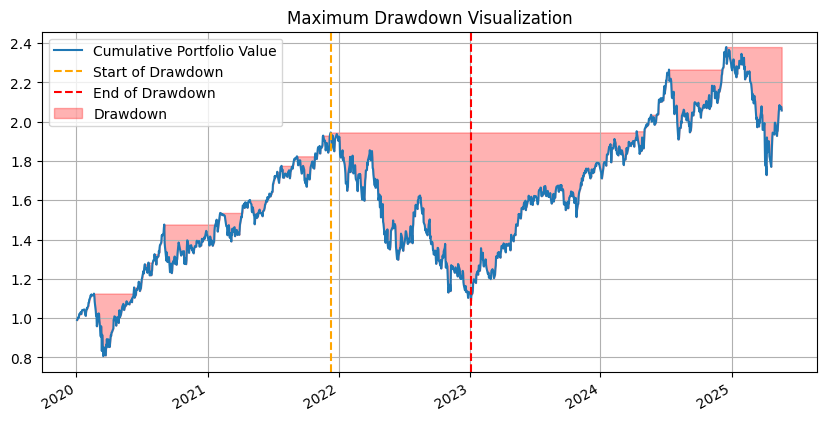

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
cum_port.plot(label='Cumulative Portfolio Value')
plt.axvline(start_date, color='orange', linestyle='--', label='Start of Drawdown')
plt.axvline(end_date, color='red', linestyle='--', label='End of Drawdown')
plt.fill_between(cum_port.index, cum_port, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Maximum Drawdown Visualization")
plt.legend()
plt.grid(True)
plt.show()


9. Expected Shortfall (CVaR)

What: Compute the average loss conditional on retums being below the 5th percentile

Why: ES gives a sense of tail risk beyond VaR.

We calculate the average loss on the worst 5% of days (those days worse than the VaR level).

This is called:

• Expected Shortfall (ES)

• or Conditional Value at Risk (CVaR)

Why do we calculate this?

Because VaR only tells you the cutoff point — not how bad things get beyond that.

VaR says: "You won't lose more than 3% on 95% of days."

But what about the other 5% of days?

• Do you lose 4%?

ES tells you how big those worst losses usually are.

Summery

  "VaR tells you where the danger zone starts. CVaR tells you how bad it usually gets once you're already in it."

This step gives a deeper picture of extreme risk — very important for investors, risk managers, and analysts.

In [ ]:
import numpy as np
from scipy import stats

alpha = 0.05  # 95% confidence level → worst 5%
z_95 = stats.norm.ppf(alpha)

# Historical Expected Shortfall
es_hist = -portR[portR <= np.percentile(portR, alpha * 100)].mean()

# Parametric (Normal) Expected Shortfall
mu_norm = portR.mean()
sigma_norm = portR.std()
es_norm = -(mu_norm - sigma_norm * stats.norm.pdf(z_95) / alpha)

print(f"Expected Shortfall (Historical ES) at 95% level: {es_hist:.5f}")
print(f"Expected Shortfall (Normal ES) at 95% level:     {es_norm:.5f}")


Expected Shortfall (Historical ES) at 95% level: 0.04230
Expected Shortfall (Normal ES) at 95% level:     0.03679


VaR Backtesting (Value-at-Risk)

Backtesting VaR means checking whether your actual losses exceeded the predicted VaR as often as expected.

Goal:

If you estimate VaR at 95%, you expect only 5% of the returns to fall below the VaR threshold. If more than that happens, your model may be inaccurate.

Step-by-Step Code for VaR Backtesting

Assuming:

You have a portfolio returns series portR

You've calculated daily 95% VaR, either constant or varying (we’ll use a constant historical one for simplicity)




In [ ]:
#Step 1: Calculate 95% Historical VaR
alpha = 0.05
var_95 = np.percentile(portR, 100 * alpha)


In [ ]:
#Step 2: Count VaR Breaches
# Breach = return is worse than VaR (i.e., more negative)
breaches = portR < var_95
num_breaches = breaches.sum()
total_obs = len(portR)
expected_breaches = int(alpha * total_obs)
breach_rate = num_breaches / total_obs


In [ ]:
#Step 3: Print Backtest Summary
print(f"Total observations: {total_obs}")
print(f"Expected breaches (at 5% level): ~{expected_breaches}")
print(f"Actual breaches: {num_breaches}")
print(f"Breach rate: {breach_rate:.2%}")

if num_breaches > expected_breaches:
    print("🚨 Too many breaches: VaR model may be underestimating risk!")
else:
    print("✅ Breach count is within acceptable range.")


Total observations: 1352
Expected breaches (at 5% level): ~67
Actual breaches: 68
Breach rate: 5.03%
🚨 Too many breaches: VaR model may be underestimating risk!


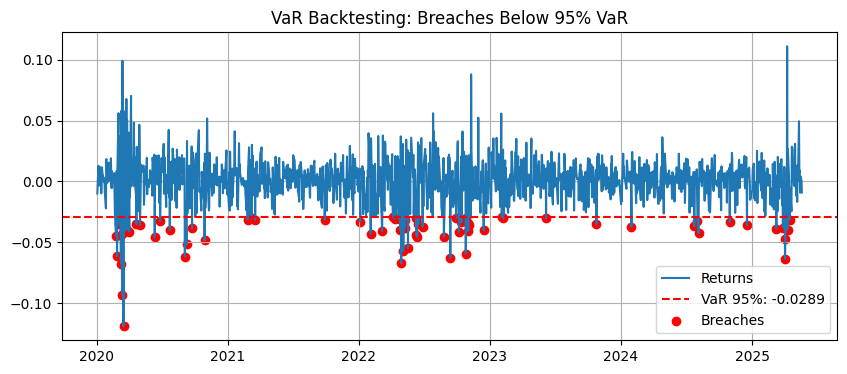

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(portR.index, portR, label="Returns")
plt.axhline(var_95, color='red', linestyle='--', label=f'VaR 95%: {var_95:.4f}')
plt.scatter(portR.index[breaches], portR[breaches], color='red', label='Breaches')
plt.title("VaR Backtesting: Breaches Below 95% VaR")
plt.legend()
plt.grid(True)
plt.show()


11. Rolling VaR Time Series

Instead of calculating a single static VaR, a rolling VaR shows how risk evolves over time. This is useful in volatile markets, where risk isn’t constant.


Goal:

Plot a time series of 1-day rolling VaR at 95% confidence based on a rolling window (e.g., past 100 days of returns).

Step-by-Step Code

Assume:

portR is your portfolio returns series as a pandas.Series.

In [ ]:
# Step 1: Define Parameters
window = 100      # Lookback window (days)
alpha = 0.05      # 95% confidence → 5% left tail


In [ ]:
#Step 2: Compute Rolling Historical VaR
rolling_var = portR.rolling(window).quantile(alpha)

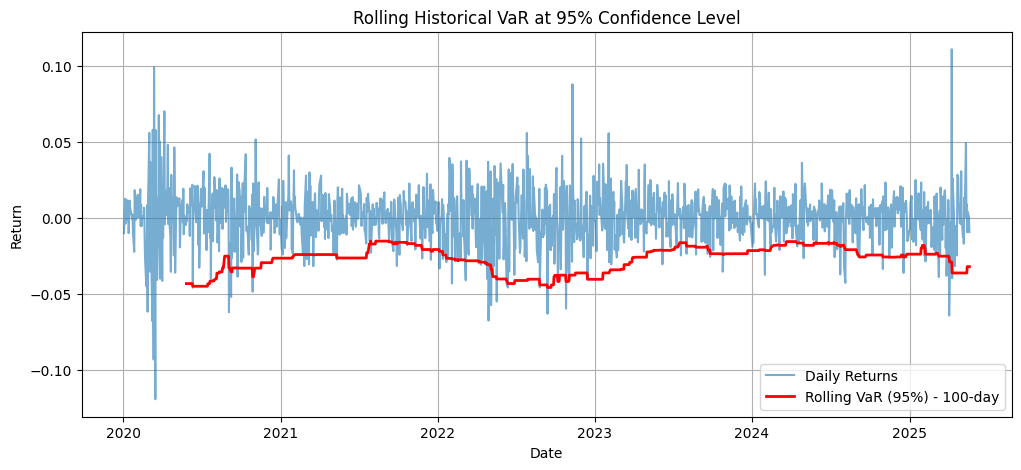

In [ ]:
# Step 3: Plot Rolling VaR and Portfolio Returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(portR.index, portR, label='Daily Returns', alpha=0.6)
plt.plot(rolling_var.index, rolling_var, color='red', label=f'Rolling VaR (95%) - {window}-day', linewidth=2)
plt.title('Rolling Historical VaR at 95% Confidence Level')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()


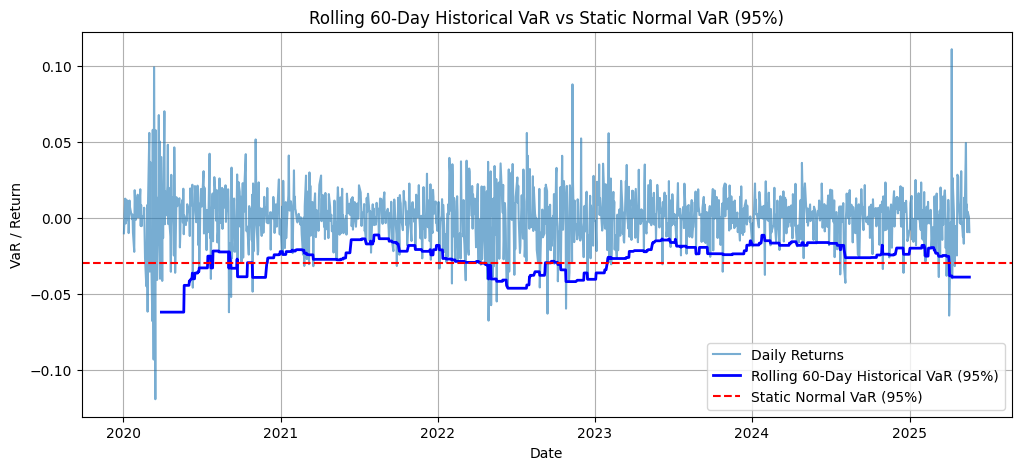

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window = 60
alpha = 0.05

# Rolling Historical VaR (95%) over 60-day window
rolling_var = portR.rolling(window).quantile(alpha)

# Static Parametric Normal VaR (based on full data)
mu = portR.mean()
sigma = portR.std()
z_95 = stats.norm.ppf(alpha)
var_norm = mu + z_95 * sigma  # For left tail, z_95 is negative

# Plot
plt.figure(figsize=(12, 5))
plt.plot(portR.index, portR, label='Daily Returns', alpha=0.6)
plt.plot(rolling_var.index, rolling_var, color='blue', label='Rolling 60-Day Historical VaR (95%)', linewidth=2)
plt.axhline(var_norm, color='red', linestyle='--', label='Static Normal VaR (95%)')

plt.title('Rolling 60-Day Historical VaR vs Static Normal VaR (95%)')
plt.ylabel('VaR / Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


12. Normality Test of Portfolio Returns

• What: Apply the Jarque—Bera test to see if retums deviate significantly from normality.

• Why: Underpins the validity of parametric VaR.

This test checks if your portfolio's daily retums look like a normal (bell-curve) distribution.

It's like asking: "Do my returns have the symmetry and shape of a standard normal curve?'

Why this is important:

Many models (like the parametric VaR) assume retums are normally distributed But in the real world, returns often have:

• Skewness (they lean left or right)

• Kurtosis (fatter tails —+ more big jumps)

This test helps you decide whether that normality assumption is valid.


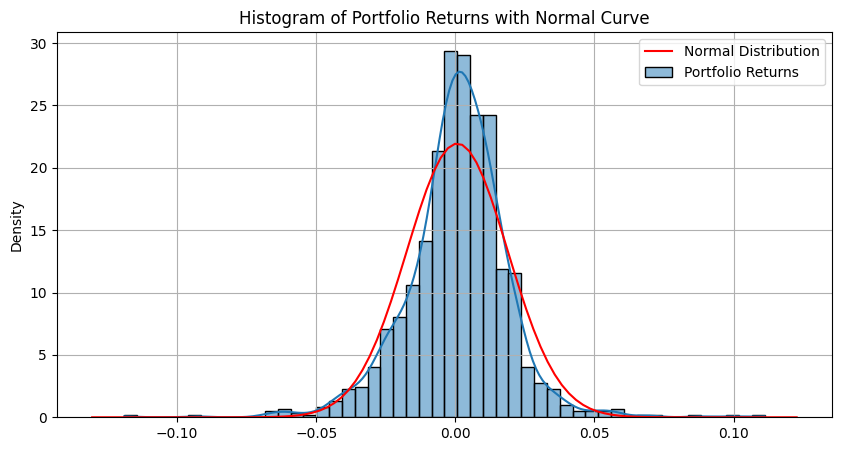

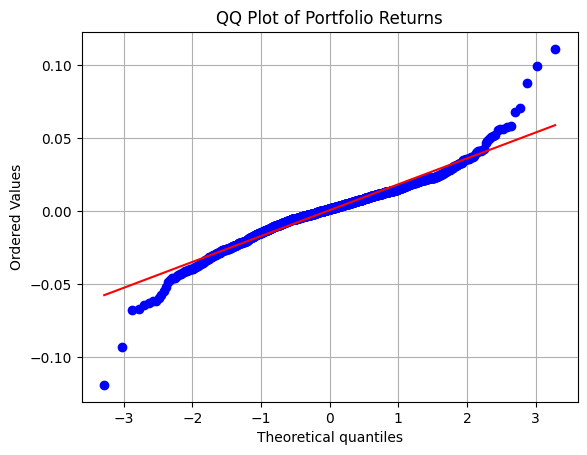

Shapiro-Wilk Test: W = 0.9514, p-value = 0.0000
❌ Reject H₀: Returns are NOT normally distributed.
Jarque-Bera Test: JB = 1185.3618, p-value = 0.0000
❌ Reject H₀: Returns are NOT normally distributed.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import jarque_bera

# Step 1: Plot Histogram with Normal Distribution Overlay
plt.figure(figsize=(10, 5))
sns.histplot(portR, bins=50, kde=True, stat="density", label='Portfolio Returns')
mean = portR.mean()
std = portR.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'r', label='Normal Distribution')
plt.title('Histogram of Portfolio Returns with Normal Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 2: QQ Plot to visually assess normality
stats.probplot(portR, dist="norm", plot=plt)
plt.title("QQ Plot of Portfolio Returns")
plt.grid(True)
plt.show()

# Step 3: Perform Shapiro-Wilk Test (for small/medium sample sizes)
# Null Hypothesis H0: Data is normally distributed
shapiro_stat, shapiro_p = stats.shapiro(portR)
print(f"Shapiro-Wilk Test: W = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
if shapiro_p < 0.05:
    print("❌ Reject H₀: Returns are NOT normally distributed.")
else:
    print("✅ Fail to reject H₀: Returns MAY be normally distributed.")

# Step 4: Perform Jarque-Bera Test (for normality in large datasets)
# H0: Data follows a normal distribution (based on skewness and kurtosis)
jb_stat, jb_p, _, _ = jarque_bera(portR)
print(f"Jarque-Bera Test: JB = {jb_stat:.4f}, p-value = {jb_p:.4f}")
if jb_p < 0.05:
    print("❌ Reject H₀: Returns are NOT normally distributed.")
else:
    print("✅ Fail to reject H₀: Returns MAY be normally distributed.")
